# UNN NLP 2021 1st Lab

We have 60,000 Stack Overflow questions from 2016-2020 and classified them into three categories:

  - HQ (target = 0): High-quality posts with 30+ score and without a single edit.
  - LQ_CLOSE (target =1): Low-quality posts that were closed by the community without a single edit.
  - LQ_EDIT (target =2): Low-quality posts with a negative score and with multiple community edits. However, they still remain open after the edits.

### Data columns
  - Body - The question' body in HTML format.
  - Tags - The question' tags (up to 5 tags per question)
  - Title - The question' title bruh…
  - Id - The question' unique identificator

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
%cd '/content/gdrive/My Drive/NLP_1_lab/'

/content/gdrive/My Drive/NLP_1_lab


In [3]:
from IPython.display import display_html 
import numpy as np
import pandas as pd
import re

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import hstack

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

from sklearn.model_selection import train_test_split

from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
raw_train_data = pd.read_parquet("train.parquet")
raw_test_data = pd.read_parquet("test.parquet")
raw_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48000 entries, 34862324 to 40415937
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Body    48000 non-null  object
 1   Tags    48000 non-null  object
 2   Title   48000 non-null  object
 3   target  48000 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.8+ MB


In [5]:
raw_train_data.head()

,Body,Tags,Title,target
Id,,,,
34862324,Algorithmm:\r\n\r\n**input :** Graph G\r\n\r\n...,<java><algorithm><graph-algorithm>,I am implementing a Minimum Spanning Forrest a...,2
47303682,"While converting the data frame to HTML, Date ...",<html><r><dataframe>,"R Studio: Date is getting converted to number,...",2
46431243,"<p>This should be an easy one, but somehow I c...",<python><pandas><dataframe><pandas-groupby>,Pandas - dataframe groupby - how to get sum of...,0
45306324,<p>Let say I have a component in Angular 2 tha...,<angular><typescript><rxjs>,Casting results from Observable.forkJoin to th...,0
49479547,<p>I'm setting a var using \n<code>set TEST_VA...,<c><windows><batch-file>,Environment variable set in batch file cannot ...,1


In [6]:
raw_test_data.head()

,Body,Tags,Title
Id,,,
46785369,I was given a decision tree with sample data i...,<math><machine-learning><artificial-intelligen...,Desecion trees ended up with same given tree a...
38908667,<p>I am moving a test application over to Xcod...,<ios><swift><swift3><xcode8><nserror>,Value of type 'Error' has no member 'code'
44703012,<p>I would like to be able to perform linting ...,<jenkins><jenkins-pipeline>,How do I lint Jenkins pipelines from the comma...
34910435,"<p>I’m using <a href=""https://github.com/ftlab...",<javascript><css><mobile-safari><fastclick.js>...,Is there a way to prevent fastclick from firin...
51632121,I have some 5 Test cases and I want them to ke...,<android><testing><appium><katalon-studio>,How to loop test cases in katalon Studio?


# EDA and preprocessing

In [7]:
sns.set(style = 'white', rc={'figure.figsize':(12, 8)})

### Посмотрим на распределение классов:

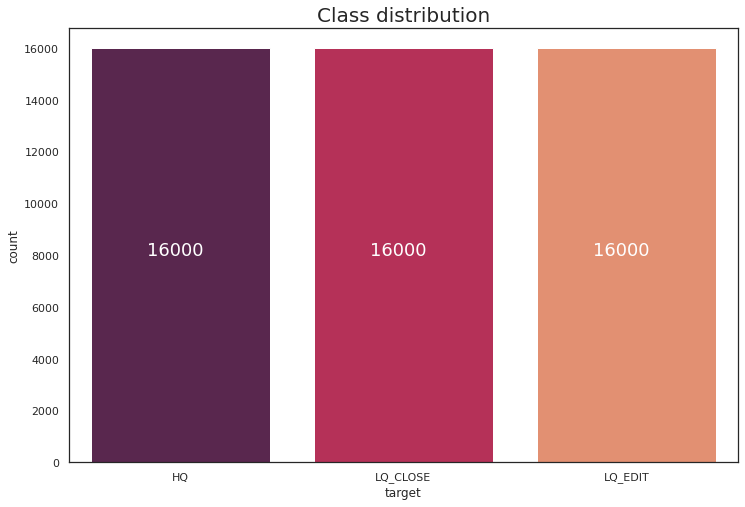

In [8]:
labels = {0:'HQ', 1:'LQ_CLOSE', 2:'LQ_EDIT'}
ax = sns.countplot(x='target', data=raw_train_data, palette ='rocket')
ax.set_title('Class distribution', fontsize=20)
ax.set_xticklabels(list(labels.values()))
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + 0.25, p.get_height() // 2), color='white', size=18)
plt.show()
pass

Классы сбалансированны.



## Tags processing

In [9]:
raw_train_data['Tags'] = raw_train_data['Tags'].str.replace('>',' ')
raw_train_data['Tags'] = raw_train_data['Tags'].str.replace('<','')
raw_train_data['Tags'] = raw_train_data['Tags'].str.split()

In [10]:
raw_train_data[['Tags']]

,Tags
Id,
34862324,"[java, algorithm, graph-algorithm]"
47303682,"[html, r, dataframe]"
46431243,"[python, pandas, dataframe, pandas-groupby]"
45306324,"[angular, typescript, rxjs]"
49479547,"[c, windows, batch-file]"
...,...
35488105,"[c#, asp.net, datetime, textbox]"
37045803,"[c#, image, detection]"
43601747,"[java, apache-kafka, kafka-producer-api]"


In [11]:
raw_test_data['Tags'] = raw_test_data['Tags'].str.replace('>',' ')
raw_test_data['Tags'] = raw_test_data['Tags'].str.replace('<','')
raw_test_data['Tags'] = raw_test_data['Tags'].str.split()

Всего уникальных тегов:

In [12]:
len(raw_train_data['Tags'].explode().unique())

9619

ТОП самых используемых тегов:

javascript    5638
python        5480
java          5031
android       3880
php           3355
c#            3347
html          2694
c++           2387
css           1692
arrays        1468
Name: Tags, dtype: int64

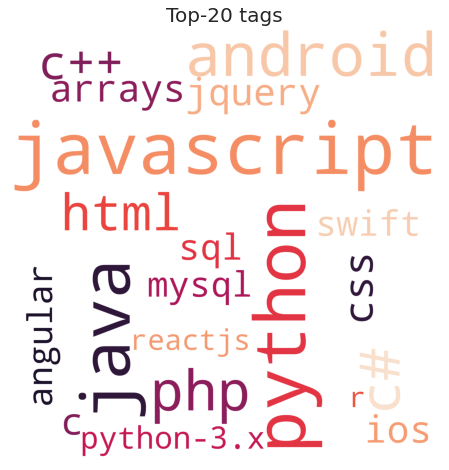

In [13]:
display(raw_train_data['Tags'].explode().value_counts()[:10])
wcloud = WordCloud(background_color = 'white', collocations=False, width = 2000, \
                   height = 2000, colormap = "rocket_r", max_words=20).generate_from_frequencies(raw_train_data['Tags'].explode().value_counts(), )
plt.axis('off')
plt.title('Top-20 tags',fontsize = 20)
plt.imshow(wcloud)
pass

Самые популярные теги по категориям:

In [14]:
explode_tags = raw_train_data.explode('Tags')
most_freq_tag_by_cat = explode_tags.groupby('target')['Tags'].apply(lambda x: x.value_counts()).reset_index()

In [15]:
space = "\xa0" * 10
hq_tags = most_freq_tag_by_cat[most_freq_tag_by_cat['target'] == 0].drop("target", axis=1).head().style.set_table_attributes("style='display:inline'").set_caption('HQ')
lq_close_tags = most_freq_tag_by_cat[most_freq_tag_by_cat['target'] == 1].drop("target", axis=1).head().style.set_table_attributes("style='display:inline'").set_caption('LQ_CLOSE')
lq_edit_tags = most_freq_tag_by_cat[most_freq_tag_by_cat['target'] == 2].drop("target", axis=1).head().style.set_table_attributes("style='display:inline'").set_caption('LQ_EDIT')
display_html(hq_tags._repr_html_() + space + lq_close_tags._repr_html_() + space + lq_edit_tags._repr_html_(), raw = True)

,level_1,Tags
0,python,1596
1,javascript,1540
2,android,1368
3,angular,913
4,java,849
,level_1,Tags
6231,javascript,2349
6232,java,2252
6233,python,2082
6234,php,1815


Теги для каждой категории пересекаются (пр. и python, javascript, java входят в топ 5 для всех категорий) и какого-то однозначного вывода о влиянии на принадлежность к категории сделать не получается.

## Title и Body processing

Посмотрим на частоту встречаемости слов в body + title + tags:


In [16]:
def top_n_words_freq(df_column, n):
  words = {}
  for x in df_column.str.split():
      for w in x:
          if w in words:
            words[w] += 1
          else:
            words[w] = 1
  top_words = sorted(words.items(), key = lambda x:x[1], reverse = True)[:n]
  x, y = zip(*top_words)
  return x, y

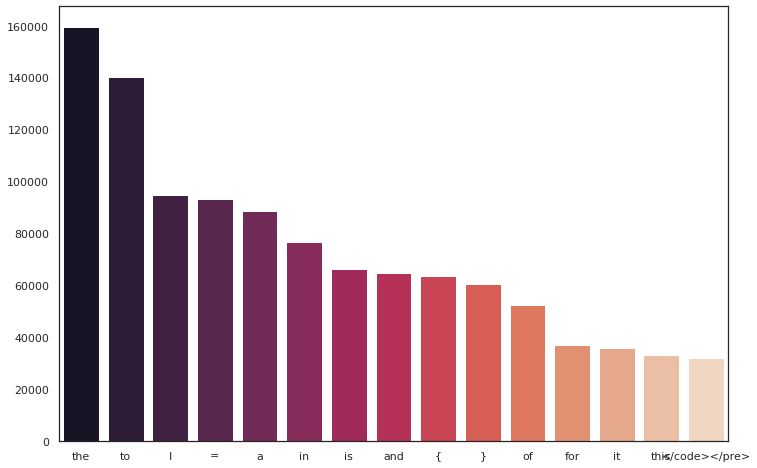

In [17]:
raw_train_data['full_info'] = raw_train_data['Tags'].apply(lambda x: ' '.join(x)) + ' ' +raw_train_data['Title'] + ' ' + raw_train_data['Body']
x, y = top_n_words_freq(raw_train_data['full_info'], 15)
sns.barplot(x = np.array(x), y = np.array(y), palette='rocket')
pass

Самые частые слова - stop-words, различные символы (=, !, {}) и теги форматирования. Попробовав убрать stop-words, выяснилось, что точность в итоге падает, поэтому в препроцессинге убираю только не-буквенные символы, и привожу все к сторочным буквам. 


In [20]:
def preprocess(data):
  preproc_data = data.copy()
  preproc_data['full_info'] = preproc_data['Tags'].apply(lambda x: ' '.join(x)) + ' ' + preproc_data['Title'] + ' ' + preproc_data['Body']
  preproc_data.drop('Tags', axis=1, inplace=True)
  preproc_data.drop('Title', axis=1, inplace=True)
  preproc_data.drop('Body', axis=1, inplace=True)

  # add is_format feature - to specify if text contains formatting
  preproc_data['is_format'] = preproc_data['full_info'].str.contains(r'<[^>]*>').astype(int)
  # preproc_data['full_info'] = preproc_data['full_info'].str.replace(r'<[^>]*>', ' ')
  # clean all trash words and symbols
  #preproc_data['full_info'] = preproc_data['full_info'].str.replace(r'\n', ' ')
  #preproc_data['full_info'] = preproc_data['full_info'].str.replace(r'\r', ' ')
  # replace shorts
  # preproc_data['full_info'] = preproc_data['full_info'].str.replace(r'n\'t', ' not')
  # preproc_data['full_info'] = preproc_data['full_info'].str.replace(r'\’ve', ' have')
  # preproc_data['full_info'] = preproc_data['full_info'].str.replace(r'\’m', ' am')
  # preproc_data['full_info'] = preproc_data['full_info'].str.replace(r'\’s', ' is')
  # remove symbols except a-zA-z and spaces
  preproc_data['full_info'] = preproc_data['full_info'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', ' ',str(x)))
  # to lower case
  preproc_data['full_info'] = preproc_data['full_info'].apply(lambda x: x.lower())
  # remove all extra spaces
  preproc_data['full_info'] = preproc_data['full_info'].apply(lambda x: ' '.join(x.split()))
  # remove stop words
  # stop = list(stopwords.words("english"))
  # preproc_data['full_info'] = preproc_data['full_info'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
  

  return preproc_data

In [21]:
preproc_train_data = preprocess(raw_train_data)
preproc_test_data = preprocess(raw_test_data)

In [22]:
preproc_train_data

,target,full_info,is_format
Id,,,
34862324,2,java algorithm graph algorithm i am implementi...,0
47303682,2,html r dataframe r studio date is getting conv...,0
46431243,0,python pandas dataframe pandas groupby pandas ...,1
45306324,0,angular typescript rxjs casting results from o...,1
49479547,1,c windows batch file environment variable set ...,1
...,...,...,...
35488105,1,c asp net datetime textbox textbox user contro...,1
37045803,1,c image detection c do something based on imag...,1
43601747,0,java apache kafka kafka producer api kafkaprod...,1


Пример того, как изменились данные после препроцессинга:

In [23]:
idx = 2
print('Before: ')
print(raw_train_data['full_info'].values[idx])
print('After: ')
print(preproc_train_data['full_info'].values[idx])

Before: 
python pandas dataframe pandas-groupby Pandas - dataframe groupby - how to get sum of multiple columns <p>This should be an easy one, but somehow I couldn't find a solution that works.</p>

<p>I have a pandas dataframe which looks like this:</p>

<pre><code>index col1   col2   col3   col4   col5
0     a      c      1      2      f 
1     a      c      1      2      f
2     a      d      1      2      f
3     b      d      1      2      g
4     b      e      1      2      g
5     b      e      1      2      g
</code></pre>

<p><strong>I want to group by col1 and col2 and get the <code>sum()</code> of col3 and col4.</strong> <code>Col5</code> can be dropped, since the data can not be aggregated.</p>

<p>Here is how the output should look like. I am interested in having both <code>col3</code> and <code>col4</code> in the resulting dataframe. It doesn't really matter if <code>col1</code> and <code>col2</code> are part of the index or not.</p>

<pre><code>index col1   col2   col3  

Смотрим на распределение слов после препроцессинга, по прежнему самые частые слова - stop-word и остатки от html тэгов (после убирания <>). Без них точность падает.

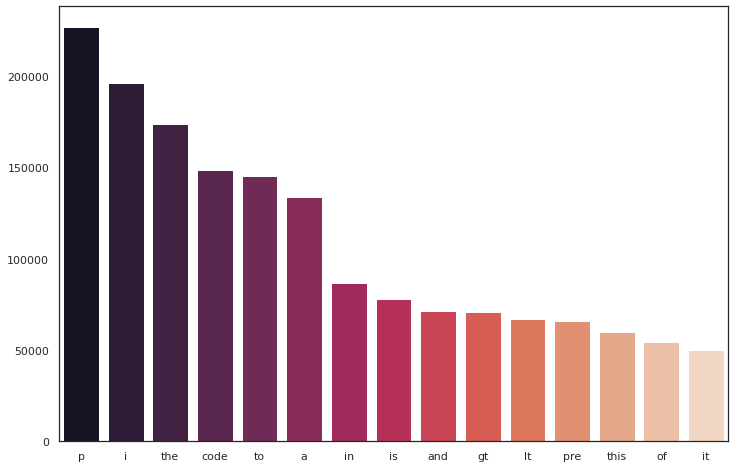

In [24]:
x, y = top_n_words_freq(preproc_train_data['full_info'], 15)
sns.barplot(x = np.array(x), y = np.array(y), palette='rocket')
pass

# Деление на тренировочную и валидационную выборки

In [25]:
train_data, val_data = train_test_split(preproc_train_data, test_size=0.2, random_state=166627, stratify=preproc_train_data['target'])
train_data.shape, val_data.shape

((38400, 3), (9600, 3))

Сохраняем обработанные данные для тренировки сети в дальнейшем (бинарую фичу на наличие/ отсутствие форматирования отбросим, т.к. для нее придется адаптировать сетку, что делать не хотелось бы)

In [26]:
train_data.drop("is_format", axis=1).to_csv("train_data.csv", index=False)
val_data.drop("is_format", axis=1).to_csv("val_data.csv", index=False)
preproc_test_data.drop("is_format", axis=1).to_csv("test_data.csv", index=False)

# Выделение target



In [27]:
train_target = train_data['target']
train_data = train_data.drop(['target'], axis = 1)
val_target = val_data['target']
val_data = val_data.drop(['target'], axis = 1)

## Будем использовать следущие классические методы ML:


1.   Логистическая регрессия
2.   SVC



In [28]:
def lr(train_x, train_y, class_weight='balanced'):
  penalty = 'l2'
  c_values = 0.01
  lr_classifier = LogisticRegression(class_weight=class_weight, max_iter=100, penalty=penalty, C=c_values)
  lr_classifier.fit(train_x, train_y)
  return lr_classifier

def SVC(train_x, train_y):
  svc_classifier = LinearSVC()
  svc_classifier.fit(train_x, train_y)
  return svc_classifier

def show_metrics(y_true, y_predict):
  print(classification_report(y_true, y_predict, digits=4))
  conf_mat = confusion_matrix(y_true, y_predict)
  sns.heatmap(conf_mat / conf_mat.astype(np.float).sum(axis=1), square=True, cmap='coolwarm', annot=True)
  pass

# Классические векторизации:

### 1. BOW

In [30]:
bow_vec = CountVectorizer()
# prepare training features
bow_train_data = train_data.copy()
train_bow_counts = bow_vec.fit_transform(bow_train_data['full_info'])
is_format_arr = bow_train_data['is_format'].values
bow_train_features = hstack((train_bow_counts, np.reshape(is_format_arr,(len(is_format_arr),1))), format='csr')
# prepare testing features
bow_val_data = val_data.copy()
val_bow_counts = bow_vec.transform(bow_val_data['full_info'])
is_format_arr = bow_val_data['is_format'].values
bow_val_features = hstack((val_bow_counts, np.reshape(is_format_arr,(len(is_format_arr),1))), format='csr')  

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


              precision    recall  f1-score   support

           0     0.9015    0.8409    0.8702      3200
           1     0.8286    0.8991    0.8624      3200
           2     0.9784    0.9609    0.9696      3200

    accuracy                         0.9003      9600
   macro avg     0.9028    0.9003    0.9007      9600
weighted avg     0.9028    0.9003    0.9007      9600



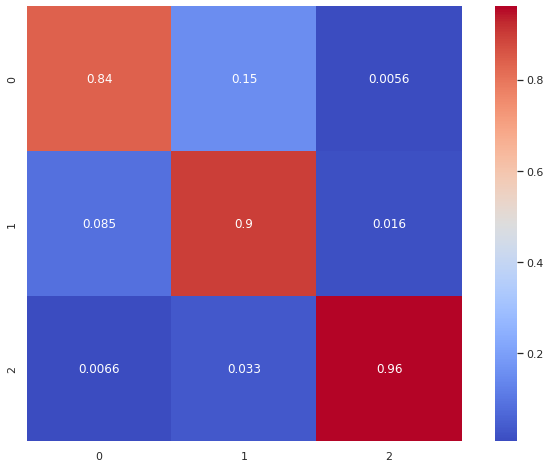

In [31]:
lr_classifier = lr(bow_train_features, train_target) 
show_metrics(val_target, lr_classifier.predict(bow_val_features))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


              precision    recall  f1-score   support

           0     0.8398    0.8206    0.8301      3200
           1     0.7890    0.8322    0.8100      3200
           2     0.9622    0.9316    0.9466      3200

    accuracy                         0.8615      9600
   macro avg     0.8637    0.8615    0.8623      9600
weighted avg     0.8637    0.8615    0.8623      9600



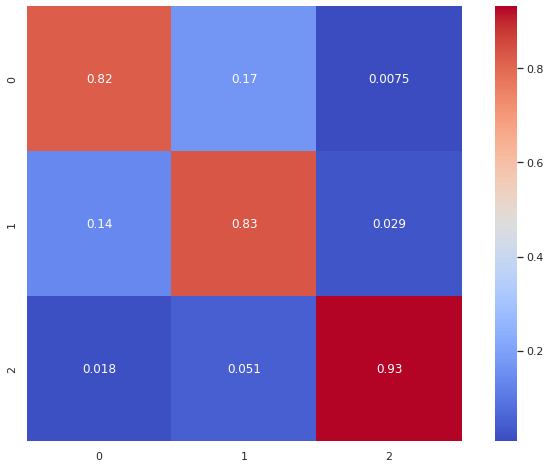

In [32]:
svc_classifier = SVC(bow_train_features, train_target)
show_metrics(val_target, svc_classifier.predict(bow_val_features))

### 2. tf-idf

In [33]:
tfidf_vec = TfidfVectorizer()
# prepare training features
tfidf_train_data = train_data.copy()
tfidf_train_data_vec = tfidf_vec.fit_transform(tfidf_train_data['full_info'])
is_format_arr = tfidf_train_data['is_format'].values
tfidf_train_features = hstack((tfidf_train_data_vec, np.reshape(is_format_arr,(len(is_format_arr),1))), format='csr')
# prepare testing features
tfidf_val_data = val_data.copy()
tfidf_val_data_vec = tfidf_vec.transform(tfidf_val_data['full_info'])
is_format_arr = tfidf_val_data['is_format'].values
tfidf_val_features = hstack((tfidf_val_data_vec, np.reshape(is_format_arr,(len(is_format_arr),1))), format='csr')

              precision    recall  f1-score   support

           0     0.7789    0.8431    0.8097      3200
           1     0.6937    0.7947    0.7408      3200
           2     1.0000    0.7719    0.8713      3200

    accuracy                         0.8032      9600
   macro avg     0.8242    0.8032    0.8072      9600
weighted avg     0.8242    0.8032    0.8072      9600



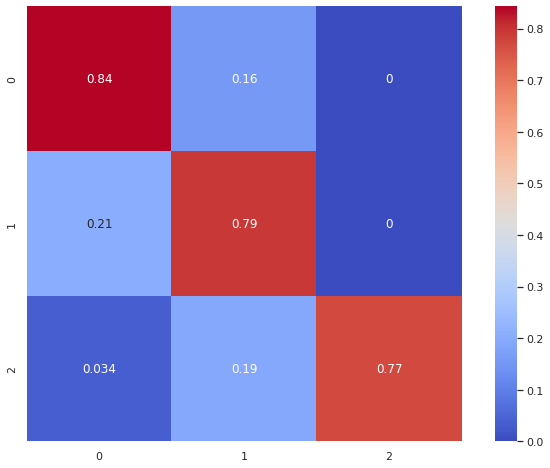

In [34]:
lr_classifier = lr(tfidf_train_features, train_target) 
show_metrics(val_target, lr_classifier.predict(tfidf_val_features))

              precision    recall  f1-score   support

           0     0.8737    0.8709    0.8723      3200
           1     0.8355    0.8634    0.8492      3200
           2     0.9758    0.9463    0.9608      3200

    accuracy                         0.8935      9600
   macro avg     0.8950    0.8935    0.8941      9600
weighted avg     0.8950    0.8935    0.8941      9600



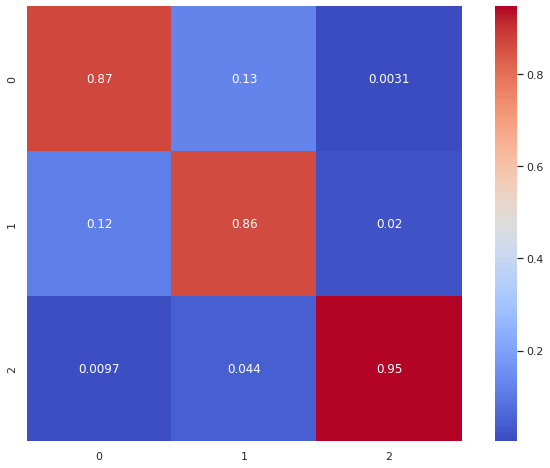

In [35]:
svc_classifier = SVC(tfidf_train_features, train_target)
show_metrics(val_target, svc_classifier.predict(tfidf_val_features))

### Результаты классификаций:

#### F1-score
---

|                   |  BOW  |  tf-idf |
|-------------------|-------|---------|
| Logistic Regression | 0.9007|  0.8072 |
| SVC  | 0.8621     |  0.8941 |

Как видно, логистическая регрессия работает лучше с BOW, а SVC - наоборот с tf-idf. Очевидно, это происходит из-за различных значений эмбеддингов получаемых после векторизаций, разные методы работают лучше с теми или другим представлениями.

# Предобученные эмбединги w2v,GloVe

In [36]:
def get_sentence_embeddings(text_data, model):
    words = text_data.split()
    embeddings = [model[word] for word in words if word in model.vocab]
    return np.mean(embeddings, axis=0)

In [211]:
import gensim.downloader 

In [212]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


## Word2Vec


In [213]:
word2vec_google_news_300 = gensim.downloader .load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [214]:
train_data

,full_info,is_format
Id,,
41464633,javascript jquery css slider slick js how to c...,0
57930235,java data conversion convert decimal to whole ...,1
38417334,javascript html url web applications store jav...,1
44373128,ruby on rails ruby will paginate rails combine...,1
48807242,amazon web services amazon s console aws s con...,1
...,...,...
42084112,android service android job scheduler not pers...,1
38627184,git pycharm pycharm to show current working br...,1
39856664,php mysql mysqli php database connection error...,1


In [215]:
w2v_train = train_data.copy()
w2v_train['full_info'] = w2v_train['full_info'].apply(lambda x : get_sentence_embeddings(x, word2vec_google_news_300))
w2v_val = val_data.copy()
w2v_val['full_info'] = w2v_val['full_info'].apply(lambda x : get_sentence_embeddings(x, word2vec_google_news_300))

Не получилось применить fit сразу к pandas.DataFrame из-за того, что в одной колонке 1D array, а в другой int. Трюк с hstack также не сработал, поэтому обучим модель только на эмбеддингах:

              precision    recall  f1-score   support

           0     0.7392    0.7378    0.7385      3200
           1     0.7096    0.5613    0.6268      3200
           2     0.7858    0.9516    0.8608      3200

    accuracy                         0.7502      9600
   macro avg     0.7449    0.7502    0.7420      9600
weighted avg     0.7449    0.7502    0.7420      9600



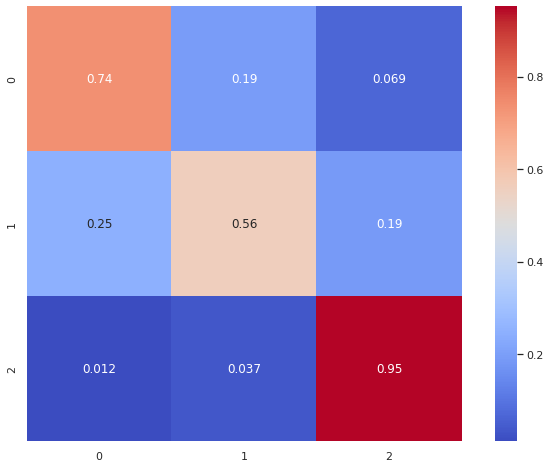

In [217]:
lr_classifier = lr(w2v_train['full_info'].to_list(), train_target) 
show_metrics(val_target, lr_classifier.predict(w2v_val['full_info'].to_list()))

              precision    recall  f1-score   support

           0     0.7778    0.8009    0.7892      3200
           1     0.7864    0.7063    0.7442      3200
           2     0.9029    0.9681    0.9344      3200

    accuracy                         0.8251      9600
   macro avg     0.8224    0.8251    0.8226      9600
weighted avg     0.8224    0.8251    0.8226      9600



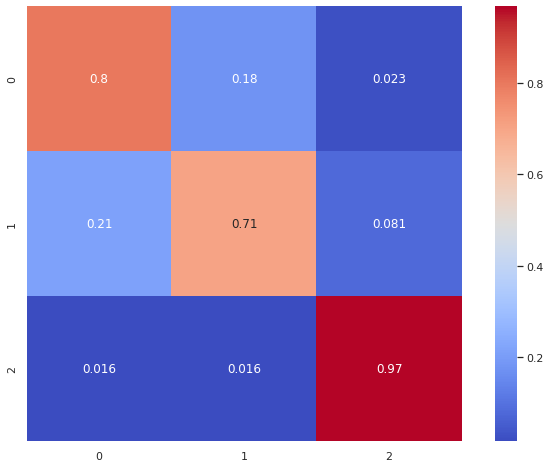

In [218]:
svc_classifier = SVC(w2v_train['full_info'].to_list(), train_target)
show_metrics(val_target, svc_classifier.predict(w2v_val['full_info'].to_list()))

## GLoVE

In [220]:
glove_wiki_gigaword_300 = gensim.downloader.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


In [221]:
glove_train = train_data.copy()
glove_train['full_info'] = glove_train['full_info'].apply(lambda x : get_sentence_embeddings(x, glove_wiki_gigaword_300))
glove_val = val_data.copy()
glove_val['full_info'] = glove_val['full_info'].apply(lambda x : get_sentence_embeddings(x, glove_wiki_gigaword_300))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


              precision    recall  f1-score   support

           0     0.7522    0.7494    0.7508      3200
           1     0.7339    0.6428    0.6853      3200
           2     0.8462    0.9544    0.8970      3200

    accuracy                         0.7822      9600
   macro avg     0.7774    0.7822    0.7777      9600
weighted avg     0.7774    0.7822    0.7777      9600



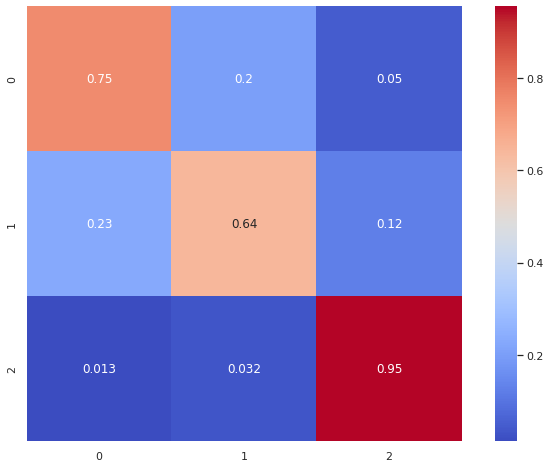

In [226]:
lr_classifier = lr(glove_train['full_info'].to_list(), train_target) 
show_metrics(val_target, lr_classifier.predict(glove_val['full_info'].to_list()))

              precision    recall  f1-score   support

           0     0.7752    0.7941    0.7845      3200
           1     0.7825    0.7094    0.7441      3200
           2     0.9032    0.9656    0.9334      3200

    accuracy                         0.8230      9600
   macro avg     0.8203    0.8230    0.8207      9600
weighted avg     0.8203    0.8230    0.8207      9600



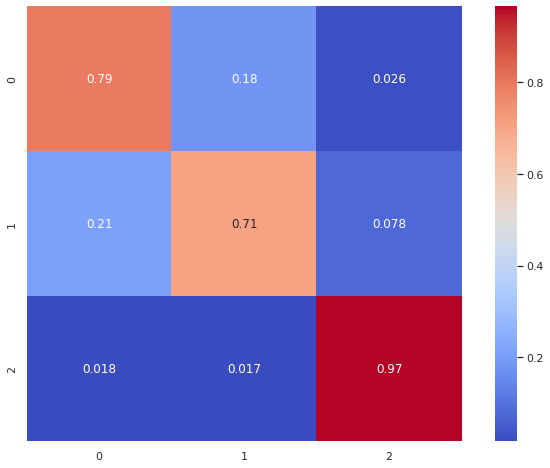

In [232]:
svc_classifier = SVC(glove_train['full_info'].to_list(), train_target) 
show_metrics(val_target, svc_classifier.predict(glove_val['full_info'].to_list()))

#### F1-score
---

|                   |  Word2Vec  |  GLoVE |
|-------------------|-------|---------|
| Logistic Regression | 0.7420|  0.7777 |
| SVC               | 0.8226  | 0.8207  | 

Получили результаты хуже, чем с методами BOW и tf-idf, вероятно из-за того, что на stackoverflow используется специфическая лексика с множеством технических терминов, которые в результате векторизации с W2V и GLOVE просто выбрасываются.

# Нейронная сеть


In [38]:
!pip install -U torchtext==0.8.0

In [76]:
 destination_folder = '/content/gdrive/My Drive/NLP_1_lab/'

In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import ConcatDataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchtext.data import Field, TabularDataset, BucketIterator, Dataset 
from torchtext.vocab import build_vocab_from_iterator
from sklearn.model_selection import KFold

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Загружаем данные:

In [78]:
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields = [('target', label_field), ('full_info', text_field)]

train_tab_dataset, valid_tab_dataset = TabularDataset.splits(path= destination_folder, train='train_data.csv', validation='val_data.csv',
                                           format='CSV', fields=fields, skip_header=True)

/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warn

In [79]:
test_tab_dataset = TabularDataset.splits(path= destination_folder, test = 'test_data.csv', format='CSV', fields=[('full_info', text_field)], skip_header=True)

/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


Создаем итераторы и строим словарь:

In [80]:
train_iter = BucketIterator(train_tab_dataset, batch_size=32, sort_key=lambda x: len(x.full_info),
                              device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid_tab_dataset, batch_size=32, sort_key=lambda x: len(x.full_info),
                            device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test_tab_dataset[0], batch_size=32, device=device, sort=False, 
                           sort_within_batch=False, shuffle = False)

/usr/local/lib/python3.7/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [81]:
text_field.build_vocab(train_tab_dataset, min_freq=3)
len(text_field.vocab)

47196

Создаем LSTM RNN 

In [86]:
class LSTM(nn.Module):
    def __init__(self, emb_size=300, hid_dim=500, dict_size=len(text_field.vocab),
                 lstm_layers_num=3,  output_size=3):
        super(LSTM, self).__init__()
        self.dict_size = dict_size
        self.hid_dim = hid_dim
        self.output_size = output_size

        self.embedding = nn.Embedding(dict_size, emb_size)
        self.lstm = nn.LSTM(input_size=emb_size,
                            hidden_size=self.hid_dim,
                            num_layers=lstm_layers_num,
                            batch_first=True,
                            bidirectional=True,
                            dropout=0.3)
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.hid_dim, self.output_size)

    def forward(self, text, text_len):
        batch_size = text.size(0)
        text_emb = self.embedding(text)
        text_emb = self.drop(text_emb)
        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, (ht, ct) = self.lstm(packed_input)
        out = self.fc(ht[-1])

        return out

In [87]:
# Save and Load Functions
def save_checkpoint(save_path, model, optimizer, valid_loss):
    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):
    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


In [88]:
def train(model,
          optimizer,
          criterion = nn.CrossEntropyLoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, (text, text_len)), _ in train_loader:           
            labels = labels.to(device)
            text = text.to(device)
            text_len = text_len.to(device)
            output = model(text, text_len.cpu())
            loss = criterion(output, labels.long())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for (labels, (text, text_len)), _ in valid_loader:
                      labels = labels.to(device)
                      text = text.to(device)
                      text_len = text_len.to(device)
                      output = model(text, text_len.cpu())
                      loss = criterion(output, labels.long())
                      valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [89]:
model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)    
train(model=model, optimizer=optimizer, num_epochs=10)

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch [1/10], Step [600/12000], Train Loss: 0.3953, Valid Loss: 0.3489
Model saved to ==> /content/gdrive/My Drive/NLP_1_lab//model.pt
Model saved to ==> /content/gdrive/My Drive/NLP_1_lab//metrics.pt
Epoch [1/10], Step [1200/12000], Train Loss: 0.3126, Valid Loss: 0.3172
Model saved to ==> /content/gdrive/My Drive/NLP_1_lab//model.pt
Model saved to ==> /content/gdrive/My Drive/NLP_1_lab//metrics.pt
Epoch [2/10], Step [1800/12000], Train Loss: 0.2279, Valid Loss: 0.2210
Model saved to ==> /content/gdrive/My Drive/NLP_1_lab//model.pt
Model saved to ==> /content/gdrive/My Drive/NLP_1_lab//metrics.pt
Epoch [2/10], Step [2400/12000], Train Loss: 0.2069, Valid Loss: 0.2590
Epoch [3/10], Step [3000/12000], Train Loss: 0.1815, Valid Loss: 0.1917
Model saved to ==> /content/gdrive/My Drive/NLP_1_lab//model.pt
Model saved to ==> /content/gdrive/My Drive/NLP_1_lab//metrics.pt
Epoch [3/10], Step [3600/12000], Train Loss: 0.1623, Valid Loss: 0.2206
Epoch [4/10], Step [4200/12000], Train Loss: 0.15

KeyboardInterrupt: ignored

Model loaded from <== /content/gdrive/My Drive/NLP_1_lab/metrics.pt


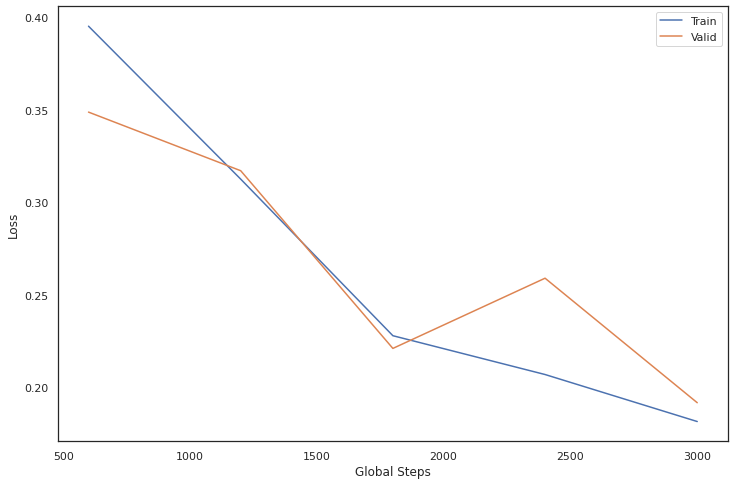

In [90]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + 'metrics.pt')
sns.lineplot(x=global_steps_list, y=train_loss_list, label='Train')
ax = sns.lineplot(x=global_steps_list, y=valid_loss_list, label='Valid')
ax.set(xlabel='Global Steps', ylabel='Loss')
plt.legend()
plt.show()

In [91]:
def predict(model, test_loader):
    y_pred = []
    y_true = []
    model.eval()
    with torch.no_grad():
        for (text, text_len), _ in test_loader:           
            text = text.to(device)
            text_len = text_len.to(device)
            output = model(text, text_len.cpu())
            y_pred.extend(output.cpu().argmax(1).detach().numpy())

    return y_pred
  
def evaluate(model, test_loader):
    y_pred = []
    y_true = []
    model.eval()
    with torch.no_grad():
        for (labels, (text, text_len)), _ in test_loader:           
            labels = labels.to(device)
            text = text.to(device)
            text_len = text_len.to(device)
            output = model(text, text_len.cpu()) # text_len.long()  ?
            y_true.extend(labels.cpu().detach().tolist())
            y_pred.extend(output.cpu().argmax(1).detach().numpy())

    return y_true, y_pred


In [92]:
best_model = LSTM().to(device)
load_checkpoint(destination_folder + 'model.pt', best_model, optimizer)
y_true, y_pred = evaluate(best_model, valid_iter)

Model loaded from <== /content/gdrive/My Drive/NLP_1_lab/model.pt


/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


              precision    recall  f1-score   support

         0.0     0.9071    0.8722    0.8893      3200
         1.0     0.8756    0.9106    0.8928      3200
         2.0     0.9991    0.9975    0.9983      3200

    accuracy                         0.9268      9600
   macro avg     0.9272    0.9268    0.9268      9600
weighted avg     0.9272    0.9268    0.9268      9600



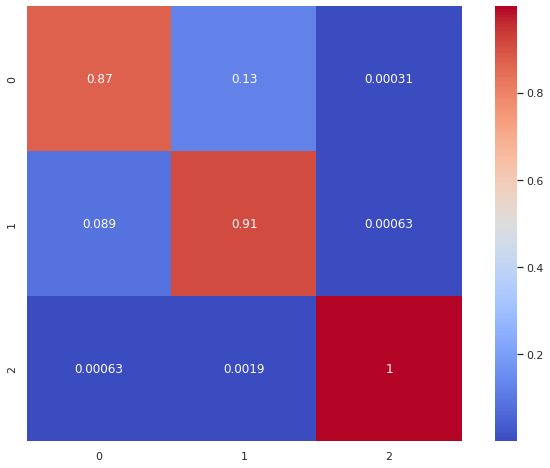

In [93]:
show_metrics(y_true, y_pred)

In [95]:
y = predict(best_model, test_iter)

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [104]:
submission = pd.DataFrame(data={'Id':raw_test_data.index.tolist(), 'Predicted': y})
submission

,Id,Predicted
0,46785369,2
1,38908667,0
2,44703012,0
3,34910435,0
4,51632121,2
...,...,...
11995,37771316,0
11996,59044957,1
11997,57190511,0
11998,35228310,2


In [102]:
submission.to_csv("submission.csv", index=False)

# Заключение:
Для участия в кэгл-соревновании использовался результат, полученный c нейронной сетью, поскольку так удалось достичь наибольшого F1-score. Но на самом деле, если затюнить параметры в классических методах ML и подобрать нужный препроцессинг, можно было бы получить аналогичный результат и там, просто это заняло бы больше 
времени. Вероятно, это значит что и из подхода с нейронной сеткой, тоже можно было бы выжать больше, подобрав нужную архитектуру и тоже затюнив параметры.
